In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# import modules
from src.features import stat_tests as st
from src.features import calculate_chart_params as cp
from src.features import functions as fn
from src.features import plot_functions as pf

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from scipy.stats import gamma
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [5]:
from statsmodels.graphics.gofplots import qqplot

#### Gamma dist

In [6]:
gamma_series = pd.Series(fn.gen_rv(gamma, args=[2], size = 100))

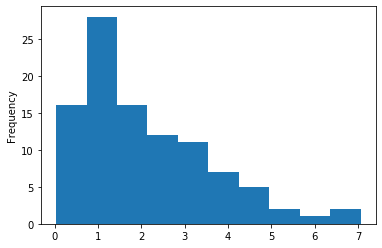

In [7]:
gamma_series.plot.hist()

#### Test for normality

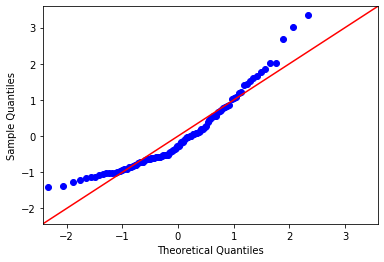

In [8]:
fig = qqplot(gamma_series, fit=True, line='45')
plt.show()

In [9]:
st.shapiro_wilks_(gamma_series)

Statistics=0.912, p=0.000
Sample does not look Gaussian (reject H0)


In [10]:
st.jarque_bera_(gamma_series)

Statistics=22.759, p=0.000, skew=1.087, kurt=3.858
Sample does not look Gaussian (reject H0)


#### Individual control chart

In [11]:
in_control_mean = gamma_series.mean()

In [12]:
MR  = cp.calculate_MR(gamma_series)
in_control_sigma = cp.estimate_sigma_from_MR(MR)

In [13]:
in_control_mean, in_control_sigma

(2.113958909845155, 1.5248332262835478)

In [14]:
x_ind_params = cp.x_ind_params(x = gamma_series, sigma = in_control_sigma, center=in_control_mean)

In [15]:
x_ind_params = x_ind_params.reset_index()

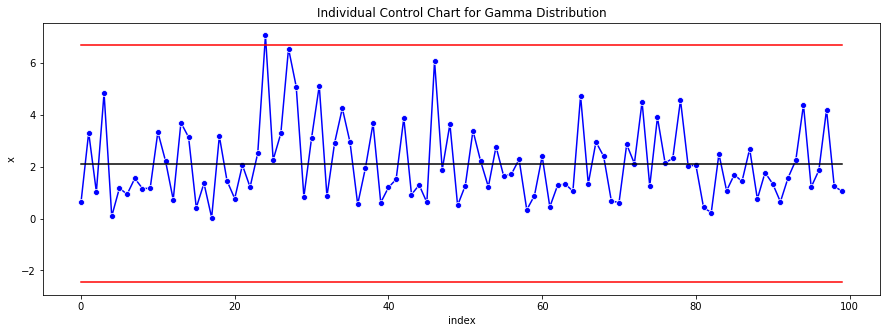

In [16]:
pf.plot_control_chart(
    data=x_ind_params,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title='Individual Control Chart for Gamma Distribution',
    ylab='x',
    xlab=None,
    all_dates=False,
    rot=0)

#### Transform gamma dist with boxcox

In [17]:
gamma_series_transformed = pd.Series(boxcox(gamma_series)[0])

In [18]:
lambda_bc = boxcox(gamma_series)[1]

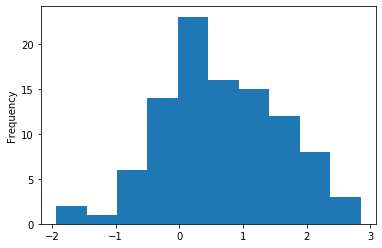

In [19]:
gamma_series_transformed.plot.hist()

#### Test for normality

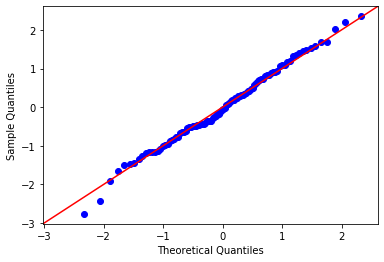

In [20]:
fig = qqplot(gamma_series_transformed, fit=True, line='45')
plt.show()

In [21]:
st.shapiro_wilks_(gamma_series_transformed)

Statistics=0.993, p=0.903
Sample looks Gaussian (fail to reject H0)


In [22]:
st.jarque_bera_(gamma_series_transformed)

Statistics=0.129, p=0.938, skew=-0.010, kurt=2.825
Sample looks Gaussian (fail to reject H0)


#### Individual control chart (transformed)

In [23]:
in_control_mean = gamma_series_transformed.mean()

In [24]:
MR  = cp.calculate_MR(gamma_series_transformed)
in_control_sigma = cp.estimate_sigma_from_MR(MR)

In [25]:
in_control_mean, in_control_sigma

(0.648266780254076, 1.0047389334932273)

In [26]:
x_ind_params = cp.x_ind_params(x = gamma_series_transformed, sigma = in_control_sigma, center=in_control_mean)

In [27]:
x_ind_params = x_ind_params.reset_index()

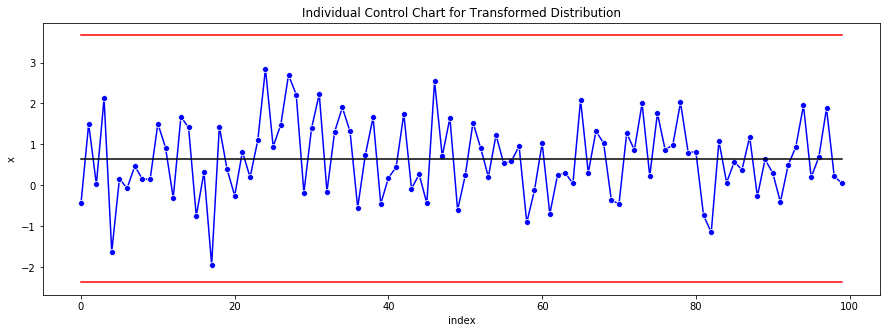

In [28]:
pf.plot_control_chart(
    data=x_ind_params,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title='Individual Control Chart for Transformed Distribution',
    ylab='x',
    xlab=None,
    all_dates=False,
    rot=0)

#### Back transform to original

In [29]:
x_ind_params2 = x_ind_params.copy()

In [30]:
x_ind_params2['obs'] = inv_boxcox(x_ind_params2['obs'], lambda_bc)
x_ind_params2['UCL'] = inv_boxcox(x_ind_params2['UCL'], lambda_bc)
x_ind_params2['Center'] = inv_boxcox(x_ind_params2['Center'], lambda_bc)
x_ind_params2['LCL'] = inv_boxcox(x_ind_params2['LCL'], lambda_bc)

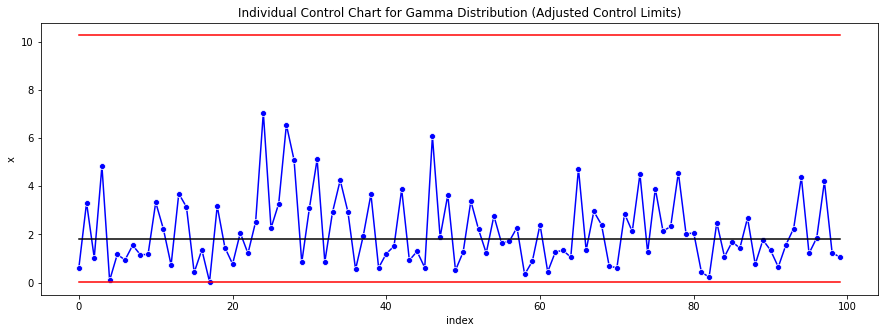

In [31]:
pf.plot_control_chart(
    data=x_ind_params2,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title='Individual Control Chart for Gamma Distribution (Adjusted Control Limits)',
    ylab='x',
    xlab=None,
    all_dates=False,
    rot=0)